## Implement a Strategy Learner

Implement a Strategy Learner and plot the results

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import pandas as pd
import util as ut
import numpy as np
import QLearner as ql

# Pretty display for notebooks
%matplotlib inline

In [2]:
class StrategyLearner(object):

    # constructor
    def __init__(self, window=15, verbose = False):
        self.verbose = verbose
        self.window = window

    # this method should create a QLearner, and train it for trading
    def addEvidence(self, symbol = "GOOG", \
        sd=dt.datetime(2004,8,19), \
        ed=dt.datetime(2005,8,19), \
        sv = 10000): 

        syms=[symbol]
        dates = pd.date_range(sd, ed)

        # read price data
        prices_all = ut.get_data(syms, dates)  # automatically adds SPY
        prices = prices_all[syms]  # only portfolio symbols
        prices_SPY = prices_all['SPY']  # only SPY, for comparison later
        if self.verbose: print prices.head()

        # discretize ratio close/SMA
        ratio_close_SMA = ut.compute_ratio_close_SMA(prices, window=self.window)
        ratio_close_SMA.dropna(inplace=True)
        self.ratio_close_SMA_thresholds = ut. compute_discretizing_thresholds(ratio_close_SMA[symbol], steps=10)
        discrete_close_SMA = ut.discretize_df_thresholds(ratio_close_SMA[symbol], \
                self.ratio_close_SMA_thresholds)

        # discretize percent_b
        percent_b = ut.compute_percent_b(prices, window=self.window)
        percent_b.dropna(inplace=True)
        self.percent_b_thresholds = ut.compute_discretizing_thresholds(
        percent_b[symbol], steps=10)
        discrete_percent_b = ut.discretize_df_thresholds(percent_b[symbol],\
                self.percent_b_thresholds)

        # compute daily returns of the stock
        stock_daily_returns = ut.compute_daily_returns(prices)

        # compute daily absolute changes of the stock
        stock_daily_changes = ut.compute_daily_changes(prices)

        # initiate a Q-learner
        self.learner = ql.QLearner(num_states=3000,\
            num_actions = 3, \
            alpha = 0.2, \
            gamma = 0.9, \
            rar = 0.98, \
            radr = 0.9999, \
            dyna = 0, \
            verbose=False) 

        # initiate cumulative return
        cumulative_return = list() 

        num_trials = 300
        for trial in range(0,num_trials): 
            
            # initiate holding (holding takes values -1, 0 , 1)
            holding = 0
            # initiate portfolio value
            portfolio = sv 

            ## for each day in the training data with features 
            # set the state and get the first action
            state_since_entry = ut.discretize_return_since_entry(portfolio, sv, threshold=0.1)
            state = ut.stack_digits([holding+1,\
                    state_since_entry, \
                    discrete_close_SMA[0],\
                    discrete_percent_b[0]]) 

            action = self.learner.querysetstate(state) 
            holding = action - 1 

            ##move to new state according to action and then get a new action
            for t in discrete_close_SMA[1:].index.tolist(): 

                # daily return as rewards
                r = stock_daily_returns[symbol][t] * holding

                state_since_entry = ut.discretize_return_since_entry(portfolio, sv, threshold=0.1)

                state = ut.stack_digits([holding+1, \
                        state_since_entry, \
                        discrete_close_SMA[t], \
                        discrete_percent_b[t]]) 

                action = self.learner.query(state,r)

                #update portfolio value
                portfolio += stock_daily_changes[symbol][t] * holding * 100
                holding = action - 1

            cumulative_return.append(portfolio/sv - 1)

        #print "cumulative return of training:",cumulative_return[-1]

        return cumulative_return


    # this method should use the existing policy and test it against new data
    def testPolicy(self, symbol = "IBM", \
        sd=dt.datetime(2009,12,31), \
        ed=dt.datetime(2011,12,31), \
        sv = 10000):

        syms=[symbol]
        dates = pd.date_range(sd, ed)

        # read price data
        prices_all = ut.get_data(syms, dates)  # automatically adds SPY
        prices = prices_all[syms]  # only portfolio symbols
        prices_SPY = prices_all['SPY']  # only SPY, for comparison later

        # discretize ratio close/SMA
        ratio_close_SMA = ut.compute_ratio_close_SMA(prices, window=self.window)
        ratio_close_SMA.dropna(inplace=True)
        discrete_close_SMA = ut.discretize_df_thresholds(ratio_close_SMA[symbol], \
                self.ratio_close_SMA_thresholds)

        # discretize percent_b
        percent_b = ut.compute_percent_b(prices, window=self.window)
        percent_b.dropna(inplace=True)
        discrete_percent_b = ut.discretize_df_thresholds(percent_b[symbol],\
                self.percent_b_thresholds)

        # compute daily returns of the stock
        stock_daily_returns = ut.compute_daily_returns(prices)

        # compute daily absolute changes of the stock
        stock_daily_changes = ut.compute_daily_changes(prices)

        holding = 0
        portfolio = sv 

        trades = prices_all[[symbol,]]  # only portfolio symbols
        trades.values[:,:] = 0 # set them all to nothing

        for t in discrete_close_SMA.index.tolist(): 

            # compute current state
            state_since_entry = ut.discretize_return_since_entry(portfolio, sv, threshold=0.1)
            state = ut.stack_digits([holding+1, \
                    state_since_entry, \
                    discrete_close_SMA[t], \
                    discrete_percent_b[t]]) 
            action = self.learner.querysetstate(state) 

            #update portfolio value
            portfolio += stock_daily_changes[symbol][t] * holding * 100
            old_holding = holding
            holding = action - 1
            trades[symbol][t] = (holding - old_holding) * 100

        cumulative_return = portfolio/sv - 1

        #print "cumulative return of testing:",cumulative_return

        return trades, cumulative_return


In [3]:
# set parameters for training the learner
symbol = "IBM"
sd_train = dt.datetime(2007,12,31)
ed_train = dt.datetime(2009,12,31) 

# set parameters for testing
sd_test = dt.datetime(2009,12,31)
ed_test = dt.datetime(2011,12,31) 

# get some data for reference
syms=[symbol]
dates = pd.date_range(sd_test, ed_test)
prices_all = ut.get_data(syms, dates)  # automatically adds SPY
prices = prices_all[syms]  # only portfolio symbols

# compute benchmark
sv =10000
cumulative_return_buy_hold_strategy = ((prices.ix[-1,:][0]- prices.ix[0,:][0])*100+sv)/sv - 1
print "cumulative return of buy-and-hold strategy:",\
        cumulative_return_buy_hold_strategy 



cumulative return of buy-and-hold strategy: 0.50186877


simulation: 0
cumulative return on testing for the last trial: 1.67884508


/home/siting/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel/__main__.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


simulation: 1
cumulative return on testing for the last trial: 1.6928224
simulation: 2
cumulative return on testing for the last trial: 1.58882911
simulation: 3
cumulative return on testing for the last trial: 1.79280029
simulation: 4
cumulative return on testing for the last trial: 1.65192434
simulation: 5
cumulative return on testing for the last trial: 1.65993212
simulation: 6
cumulative return on testing for the last trial: 1.6144619
simulation: 7
cumulative return on testing for the last trial: 1.50701599
simulation: 8
cumulative return on testing for the last trial: 1.49393026
simulation: 9
cumulative return on testing for the last trial: 1.2937939


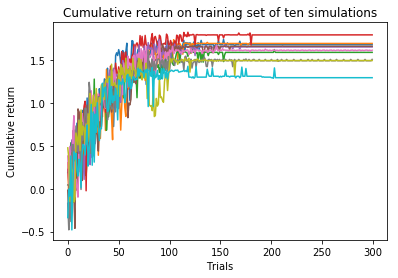

cumulative_returns_train [ 1.67884508  1.6928224   1.58882911  1.79280029  1.65192434  1.65993212
  1.6144619   1.50701599  1.49393026  1.2937939 ]
cumulative_returns_test [ 0.24914708  0.30883137  0.2502211   0.4400323   0.53603094  0.33906875
  0.47236094  0.1404276   0.08605978  0.30198513]


In [5]:
# do num_simulatoins
num_simulation = 10

cumulative_returns_train = np.zeros(num_simulation)
cumulative_returns_test = np.zeros(num_simulation)

for i in range(0,num_simulation): 
    # instantiate the strategy learner
    learner = StrategyLearner(verbose = False)

    # training
    cumulative_return = learner.addEvidence(symbol = symbol,\
                sd = sd_train, \
                ed = ed_train, sv = 10000) 

    cumulative_returns_train[i] = cumulative_return[-1]
    print "simulation:", i
    print "cumulative return on testing for the last trial:", cumulative_returns_train[i]

    # test the learner
    df_trades, cumulative_returns_test[i] = learner.testPolicy(symbol = symbol, sd = sd_test, \
    ed = ed_test, sv = 10000)
    
    plt.plot(cumulative_return)

plt.title("Cumulative return on training set of ten simulations")
plt.ylabel("Cumulative return")
plt.xlabel("Trials")
plt.show()

print "cumulative_returns_train", cumulative_returns_train 
print "cumulative_returns_test", cumulative_returns_test


In [6]:
mean_cumulative_return_train = np.mean(cumulative_returns_train)
std_cumulative_retun_train = np.std(cumulative_returns_train)

mean_cumulative_returns_test = np.mean(cumulative_returns_test )
std_cumulative_returns_test = np.std(cumulative_returns_test)

print "for 10 simulations, the mean and std of training returns:", mean_cumulative_return_train, std_cumulative_retun_train 
print "for 10 simulations, the mean and std of testing returns:", mean_cumulative_returns_test, std_cumulative_returns_test


for 10 simulations, the mean and std of training returns: 1.597435539 0.131232486362
for 10 simulations, the mean and std of testing returns: 0.312416499 0.134681950105


In [8]:
print learner.learner.Q[0:2200]

[[  1.35309556e-02   2.74643165e-02   1.07015929e-02]
 [  1.87413777e-04   2.38467894e-02   5.95180053e-03]
 [  3.79358691e-02   1.69871773e-02   1.29094594e-02]
 ..., 
 [  2.18362438e-02   0.00000000e+00  -1.70058250e-05]
 [ -2.57851964e-03   0.00000000e+00   2.38593942e-02]
 [  1.19533653e-03   1.09199351e-02  -1.59223402e-03]]
